In [1]:
if 0:
    !nvidia-smi
    
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book
    
    from google.colab import drive
    #drive.mount('/content/drive')

import fastai.test_utils
fastai.test_utils.show_install()

Thu May  6 15:51:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Human Numbers

In [1]:
import fastai.test_utils
fastai.test_utils.show_install()



```text
=== Software === 
python       : 3.8.8
fastai       : 2.3.0
fastcore     : 1.3.19
fastprogress : 0.2.7
torch        : 1.7.1
torch cuda   : 10.2 / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.10
distro       : #1 SMP Fri Apr 2 22:23:49 UTC 2021
conda env    : fastbook
python       : /home/sandmann/anaconda3/envs/fastbook/bin/python
sys.path     : /home/sandmann/repo/fastai/dev_nbs/course/selfmade
/home/sandmann/anaconda3/envs/fastbook/lib/python38.zip
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/lib-dynload

/home/sandmann/.local/lib/python3.8/site-packages
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/site-packages
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/site-packages/IPython/extensions
/home/sandmann/.ipython
no supported gpus found on this system
```

Please make sure to include openin

In [2]:
import fastai.test_utils
fastai.test_utils.show_install()



```text
=== Software === 
python        : 3.8.8
fastai        : 2.3.0
fastcore      : 1.3.19
fastprogress  : 0.2.7
torch         : 1.7.1
torch cuda    : 10.2 / is available
torch cudnn   : 7605 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : NVIDIA GeForce GTX 970

=== Environment === 
platform      : Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.10
distro        : #1 SMP Fri Apr 2 22:23:49 UTC 2021
conda env     : fastbook
python        : /home/sandmann/anaconda3/envs/fastbook/bin/python
sys.path      : /home/sandmann/repo/fastai/dev_nbs/course/selfmade
/home/sandmann/anaconda3/envs/fastbook/lib/python38.zip
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/lib-dynload

/home/sandmann/.local/lib/python3.8/site-packages
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/site-packages
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/site-packages/IPython/extensions
/home/sandmann/.ipython
no n

In [3]:
from fastai.text.all import *

In [4]:
bs = 64

# Data

In [5]:
path = untar_data(URLs.HUMAN_NUMBERS)

In [6]:
path.ls()

(#2) [Path('/home/sandmann/.fastai/data/human_numbers/valid.txt'),Path('/home/sandmann/.fastai/data/human_numbers/train.txt')]

In [7]:
def readnums(fn): return ', '.join([o.strip() for o in (path/fn).readlines()])

In [8]:
train_txt = readnums('train.txt')

In [9]:
valid_txt = readnums('valid.txt')

In [10]:
train_txt[:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [11]:
valid_txt[:80]

'eight thousand one, eight thousand two, eight thousand three, eight thousand fou'

In [12]:
train_tok = tokenize1(train_txt, tok=WordTokenizer())
valid_tok = tokenize1(valid_txt, tok=WordTokenizer())

In [13]:
dsets = Datasets([train_tok, valid_tok], tfms=Numericalize, dl_type=LMDataLoader, splits=[[0], [1]])

In [14]:
dls = dsets.dataloaders(bs=bs, val_bs=bs)

In [15]:
dsets.show((dsets.train[0][0][:80],)) # ???

In [16]:
len(dsets.valid[0][0])

13017

In [17]:
dls.seq_len, len(dls.valid)

(72, 3)

In [18]:
13017/72/bs # -> len(dls.valid)

2.8248697916666665

In [19]:
dls.valid

In [20]:
it = iter(dls.valid)
x1, y1 = next(it)
x2, y2 = next(it)
x3, y3 = next(it)
it.close()

In [21]:
x1.numel() + x2.numel() + x3.numel()

12992

In [22]:
x1.shape, x2.shape, x3.shape

(torch.Size([64, 72]), torch.Size([64, 72]), torch.Size([64, 59]))

In [23]:
x1.shape, y1.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [24]:
x3.shape, y3.shape

(torch.Size([64, 59]), torch.Size([64, 59]))

In [25]:
x1[0]

LMTensorText([ 2, 19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19,
        11, 16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,
         9, 19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19,
        11, 33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11, 37],
       device='cuda:0')

In [26]:
y1[0]

TensorText([19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19, 11,
        16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,  9,
        19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19, 11,
        33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11, 37,  9],
       device='cuda:0')

In [27]:
v = dls.vocab

In [28]:
type(v)

list

In [29]:
def translate(t): return ' '.join(v[n] for n in t)

In [30]:
translate(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand eighteen'

In [31]:
translate(y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand eighteen ,'

In [32]:
translate(x2[0])

', eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two , eight thousand thirty three'

In [33]:
translate(x3[0])

', eight thousand thirty four , eight thousand thirty five , eight thousand thirty six , eight thousand thirty seven , eight thousand thirty eight , eight thousand thirty nine , eight thousand forty , eight thousand forty one , eight thousand forty two , eight thousand forty three , eight thousand forty four , eight thousand forty five'

In [34]:
translate(x1[1])

', eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand'

# Models

## Single fully connected model

In [35]:
dls = dsets.dataloaders(bs=bs, seq_len=3)

In [36]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [37]:
nv = len(v)
nv

40

In [38]:
nh = 64

In [39]:
def loss4(input, target): return F.cross_entropy(input, target[:,-1])
def acc4(input, target): return accuracy(input, target[:,-1])

In [40]:
class Model0(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1] > 1:
            h += self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1] > 2:
            h += self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [41]:
learn = Learner(dls, Model0(), loss_func=loss4, metrics=acc4)

In [42]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.555769,3.495897,0.143842,00:05
1,2.563906,2.653986,0.420267,00:05
2,2.086474,2.279469,0.433824,00:05
3,1.900692,2.144831,0.444623,00:05
4,1.831490,2.103209,0.448989,00:05
5,1.816709,2.097742,0.449678,00:05


## Loop

In [43]:
class Model1(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh, device=x.device)
        for i in range(x.shape[1]):
            h += self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [44]:
learn = Learner(dls, Model1(), loss_func=loss4, metrics=acc4)

In [45]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.496947,3.475185,0.159467,00:05
1,2.593280,2.643381,0.439568,00:05
2,2.083721,2.233952,0.462316,00:05
3,1.877224,2.095430,0.465074,00:04
4,1.802597,2.055728,0.465074,00:05
5,1.787141,2.050444,0.465074,00:05


## Multi fully connected model

In [46]:
dls = dsets.dataloaders(bs=bs, seq_len=20)

In [47]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [48]:
class Model2(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            #h += self.i_h(x[:,i]) # += doesnt work for some reason
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.h_o(self.bn(h)))
        return torch.stack(res, dim=1)
        

In [49]:
learn = Learner(dls, Model2(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [50]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.728884,3.853620,0.002983,00:01
1,3.645074,3.704678,0.032528,00:01
2,3.470058,3.487086,0.091974,00:01
3,3.254564,3.286129,0.139725,00:01
4,3.046650,3.120043,0.228930,00:01
5,2.869650,3.002830,0.285630,00:01
6,2.733109,2.930429,0.299503,00:01
7,2.637965,2.891962,0.303338,00:01
8,2.579504,2.877158,0.306913,00:01
9,2.548960,2.874944,0.307268,00:01


# Maintain State

In [51]:
class Model3(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs,nh).cuda()
        
    def forward(self,x):
        if self.h.shape[0] != x.shape[0]: self.h = torch.zeros(x.shape[0], nh).cuda()
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
            res.append(h)
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res
    
    def reset(self): self.h = torch.zeros(bs,nh).cuda()

In [52]:
learn = Learner(dls, Model3(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.015848932787775993)

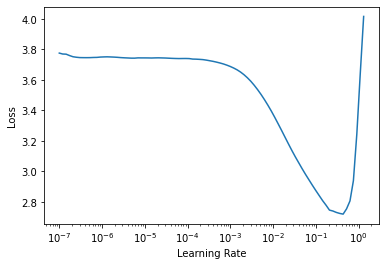

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.484245,3.225712,0.269437,00:01
1,2.843296,2.180079,0.451634,00:01
2,2.140190,1.874390,0.466383,00:01
3,1.698140,1.751840,0.515625,00:01
4,1.386867,1.699630,0.550497,00:01
5,1.142613,1.680185,0.567448,00:01
6,0.956874,1.654139,0.604474,00:01
7,0.816348,1.668332,0.624716,00:01
8,0.711335,1.621589,0.651255,00:01
9,0.629386,1.547156,0.676705,00:01


# nn.RNN

In [55]:
class Model4(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self,x):
        if x.shape[0] != self.h.shape[1]: self.h = torch.zeros(1,x.shape[0],nh).cuda()
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [56]:
learn = Learner(dls, Model4(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [57]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.515987,3.189934,0.247017,00:01
1,2.730938,2.138033,0.459943,00:00
2,2.055705,2.001947,0.318632,00:01
3,1.725459,2.074347,0.320028,00:01
4,1.560170,1.887988,0.423414,00:00
5,1.432522,1.687105,0.439086,00:00
6,1.245600,1.491018,0.487760,00:00
7,1.078878,1.413929,0.513494,00:00
8,0.928693,1.434500,0.506795,00:00
9,0.800287,1.376976,0.541051,00:00


## 2-layer GRU

In [58]:
class Model5(Module):
  def __init__(self):
    self.i_h = nn.Embedding(nv,nh)
    self.rnn = nn.GRU(nh,nh,2, batch_first=True)
    self.h_o = nn.Linear(nh,nv)
    self.bn = BatchNorm1dFlat(nh)
    self.h = torch.zeros(2,bs,nh).cuda()

  def forward(self,x):
    if x.shape[0] != self.h.shape[1]: self.h = torch.zeros(2,x.shape[0],nh).cuda()
    res, h = self.rnn(self.i_h(x), self.h)
    self.h = h.detach()
    return self.h_o(self.bn(res))

In [59]:
learn = Learner(dls, Model5(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [60]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.626052,2.002844,0.470833,00:01
1,1.440779,1.707847,0.665459,00:01
2,0.687523,1.002470,0.807742,00:01
3,0.334666,0.967669,0.819034,00:01
4,0.173490,0.918060,0.836222,00:01
5,0.094178,0.917388,0.834612,00:01
6,0.054586,1.048424,0.827723,00:01
7,0.033259,1.003932,0.827628,00:01
8,0.021938,1.058587,0.827083,00:00
9,0.016040,1.062124,0.827060,00:01
